In [98]:
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
np.set_printoptions(suppress=True)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any, Union

In [99]:
IN_CSV_DATA = Path().cwd().parent.parent / "data/4_data_split"
OUT_MODEL_DATA = Path().cwd().parent.parent / "data/5_models"

# 1. Load in Training and Test Datasets

In [100]:
df_train = pd.read_csv(IN_CSV_DATA/'prepared_train.csv')
df_test = pd.read_csv(IN_CSV_DATA/'prepared_test.csv')

In [101]:
numerical_feature_cols = ['total_distance_mi','total_weight_lbs','avg_cruising_speed', 'log_hours_since_last_ride',
                            'active_time_ratio', 'avg_climb_rate', 'distance_training_intensity','prior_training_load']
categorical_feature_cols = []#['year']
feature_cols = numerical_feature_cols + categorical_feature_cols

target_cols = ['best_power_4s', 'best_power_5s',
                'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                'best_power_40m', 'best_power_1h', 'best_power_2h']

In [102]:
X_train, y_train = df_train[feature_cols].values, df_train[target_cols].values
X_test, y_test = df_test[feature_cols].values, df_test[target_cols].values

In [103]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_log_error
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

In [104]:
SCORING = 'r2'

In [105]:
from sklearn.linear_model import Lasso

In [106]:
tss_cv = TimeSeriesSplit(n_splits=5)

# 1a. Full Targets Vector Regressor

In [107]:
lasso_reg = Lasso()

In [108]:
param_grid = [{'alpha':[0.5, 1.0, 1.5, 2, 3, 5, 10]}] # Alpha is the gain on the regularization term
lasso_reg_gridcv = GridSearchCV(lasso_reg, param_grid, cv=tss_cv, n_jobs=-1, 
                             refit=True, return_train_score=True,
                             scoring=SCORING, verbose=1
                            )

In [109]:
# fitting the model for grid search
lasso_reg_gridcv.fit(X_train, y_train)

# print the best parameter set after tuning
print(lasso_reg_gridcv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 3}


In [110]:
cv_results = lasso_reg_gridcv.cv_results_

for train_r2, test_r2, params in zip(cv_results['mean_train_score'], cv_results['mean_test_score'], cv_results['params']):
    print(f'For params:{params}')
    print(f'\t- Train R^2={train_r2} --> Test R^2={test_r2}')
    print('-'*50)

For params:{'alpha': 0.5}
	- Train R^2=0.5534291274943661 --> Test R^2=0.18809736873938515
--------------------------------------------------
For params:{'alpha': 1.0}
	- Train R^2=0.549690483666585 --> Test R^2=0.21972790795122946
--------------------------------------------------
For params:{'alpha': 1.5}
	- Train R^2=0.5445334917501969 --> Test R^2=0.24342066173239602
--------------------------------------------------
For params:{'alpha': 2}
	- Train R^2=0.5383483733614457 --> Test R^2=0.2554018437239041
--------------------------------------------------
For params:{'alpha': 3}
	- Train R^2=0.5236938041341797 --> Test R^2=0.26636088202742436
--------------------------------------------------
For params:{'alpha': 5}
	- Train R^2=0.4864006921288295 --> Test R^2=0.2619090092368325
--------------------------------------------------
For params:{'alpha': 10}
	- Train R^2=0.3990376430162377 --> Test R^2=0.2315894635594876
--------------------------------------------------


In [111]:
model_lasso_reg = lasso_reg_gridcv.best_estimator_
df_coeficients = pd.DataFrame(model_lasso_reg.coef_, columns=feature_cols, index=target_cols)

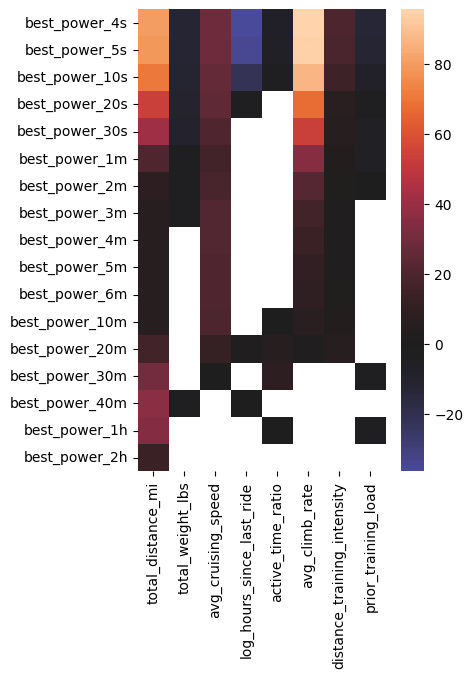

In [112]:
_ = plt.figure(figsize=(4,6))
_ = sns.heatmap(df_coeficients.replace(to_replace={0:np.nan}), center=0)

# 1b. Individual Target Regressors `MultiOutputRegressor`

In [113]:
param_grid = [{'estimator__alpha':[0.5, 1.0, 1.5, 2, 3, 5, 10]}] # Alpha is the gain on the regularization term

MO_lasso_reg = MultiOutputRegressor(Lasso())

lasso_reg_gridcv = GridSearchCV(MO_lasso_reg, param_grid, cv=tss_cv, n_jobs=-1, 
                             refit=True, return_train_score=True,
                             scoring=SCORING, verbose=1
                            )

In [114]:
# fitting the model for grid search
lasso_reg_gridcv.fit(X_train, y_train)

# print the best parameter set after tuning
print(lasso_reg_gridcv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'estimator__alpha': 3}


In [115]:
cv_results = lasso_reg_gridcv.cv_results_

for train_r2, test_r2, params in zip(cv_results['mean_train_score'], cv_results['mean_test_score'], cv_results['params']):
    print(f'For params:{params}')
    print(f'\t- Train R^2={train_r2} --> Test R^2={test_r2}')
    print('-'*50)

For params:{'estimator__alpha': 0.5}
	- Train R^2=0.5534291274943661 --> Test R^2=0.18809736873938512
--------------------------------------------------
For params:{'estimator__alpha': 1.0}
	- Train R^2=0.5496904836665848 --> Test R^2=0.21972790795122948
--------------------------------------------------
For params:{'estimator__alpha': 1.5}
	- Train R^2=0.5445334917501969 --> Test R^2=0.24342066173239602
--------------------------------------------------
For params:{'estimator__alpha': 2}
	- Train R^2=0.5383483733614457 --> Test R^2=0.2554018437239041
--------------------------------------------------
For params:{'estimator__alpha': 3}
	- Train R^2=0.5236938041341797 --> Test R^2=0.2663608820274244
--------------------------------------------------
For params:{'estimator__alpha': 5}
	- Train R^2=0.4864006921288294 --> Test R^2=0.2619090092368326
--------------------------------------------------
For params:{'estimator__alpha': 10}
	- Train R^2=0.3990376430162377 --> Test R^2=0.23158946

In [116]:
model_MO_lasso_reg = lasso_reg_gridcv.best_estimator_
MO_coefs = np.array([est.coef_ for est in model_MO_lasso_reg.estimators_])
df_coeficients = pd.DataFrame(MO_coefs, columns=feature_cols, index=target_cols)

In [117]:
model_MO_lasso_reg.estimators_[0].coef_

array([ 80.18254682, -12.0507334 ,  28.99425573, -36.33565053,
        -6.53517376,  95.65673884,  19.86355495, -12.78275033])

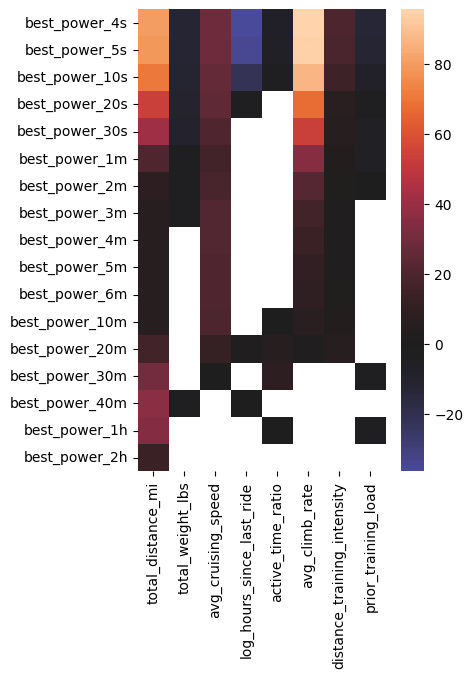

In [118]:
_ = plt.figure(figsize=(4,6))
_ = sns.heatmap(df_coeficients.replace(to_replace={0:np.nan}), center=0)

# 1c. Chain Regressor

In [151]:
param_grid = [{'base_estimator__alpha':[0.5, 1.0, 1.5, 2, 3, 5, 10]}] # Alpha is the gain on the regularization term

RC_lasso_reg = RegressorChain(Lasso(), order='random', random_state=42)

lasso_reg_gridcv = GridSearchCV(RC_lasso_reg, param_grid, cv=tss_cv, n_jobs=-1, 
                             refit=True, return_train_score=True,
                             scoring=SCORING, verbose=1
                            )

In [152]:
# fitting the model for grid search
lasso_reg_gridcv.fit(X_train, y_train)

# print the best parameter set after tuning
print(lasso_reg_gridcv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/ebauer/Documents/Code_Repos/bike-fitness-tracking/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e+04, tolerance: 1.993e+01
  model = cd_fast.enet_coordinate_descent(
/home/ebauer/Documents/Code_Repos/bike-fitness-tracking/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.934e+03, tolerance: 8.986e+00
  model = cd_fast.enet_coordinate_descent(
/home/ebauer/Documents/Code_Repos/bike-fitness-tracking/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want 

/home/ebauer/Documents/Code_Repos/bike-fitness-tracking/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.052e+04, tolerance: 4.996e+01
  model = cd_fast.enet_coordinate_descent(
/home/ebauer/Documents/Code_Repos/bike-fitness-tracking/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.064e+04, tolerance: 2.051e+01
  model = cd_fast.enet_coordinate_descent(
/home/ebauer/Documents/Code_Repos/bike-fitness-tracking/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want 

{'base_estimator__alpha': 5}


In [153]:
cv_results = lasso_reg_gridcv.cv_results_

for train_r2, test_r2, params in zip(cv_results['mean_train_score'], cv_results['mean_test_score'], cv_results['params']):
    print(f'For params:{params}')
    print(f'\t- Train R^2={train_r2} --> Test R^2={test_r2}')
    print('-'*50)

For params:{'base_estimator__alpha': 0.5}
	- Train R^2=0.5519910053649053 --> Test R^2=0.18559474812048213
--------------------------------------------------
For params:{'base_estimator__alpha': 1.0}
	- Train R^2=0.5461534995912734 --> Test R^2=0.2105153523690785
--------------------------------------------------
For params:{'base_estimator__alpha': 1.5}
	- Train R^2=0.5386249222529952 --> Test R^2=0.22852113449127437
--------------------------------------------------
For params:{'base_estimator__alpha': 2}
	- Train R^2=0.5302554092702733 --> Test R^2=0.24522521410055192
--------------------------------------------------
For params:{'base_estimator__alpha': 3}
	- Train R^2=0.5142524294286743 --> Test R^2=0.25734116047275324
--------------------------------------------------
For params:{'base_estimator__alpha': 5}
	- Train R^2=0.48566041866068793 --> Test R^2=0.2711075971347047
--------------------------------------------------
For params:{'base_estimator__alpha': 10}
	- Train R^2=0.399

In [154]:
model_RC_lasso_reg = lasso_reg_gridcv.best_estimator_

In [155]:
model_RC_lasso_reg.order_

array([ 0,  1,  5, 15, 11, 14,  8, 13,  2,  9, 16,  4,  7, 10, 12,  3,  6])

In [156]:
model_RC_lasso_reg.estimators_[0].coef_

array([ 78.90861761, -11.15357586,  26.66691552, -27.8393278 ,
        -3.76317411,  93.62836196,  16.66410631,  -5.6282975 ])

In [ ]:
model_RC_lasso_reg.estimators_[1].coef_ # LOL

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.98143514])